In [1]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats

#plots
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None
# plt.rcParams['text.usetex'] = True
# plt.rcParams["ps.usedistiller"] = 'xpdf'
# plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [85]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'

In [86]:
def get_statistics(df,index,fdf):
    osm.avg_distance(df,index,fdf)
    osm.mean_conc(df,index,fdf)
    osm.motion_statistics(df,index,fdf)
    osm.whiff_blank_duration(df,index,fdf)
    osm.trajectory_speed(df,index,fdf)
    osm.encounter_frequency(df,index,fdf,1,2)
    osm.mean_avg(df,index,fdf)

In [95]:
df = pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5')
# df.distance_from_source=df.distance_from_source*df.xsign
# df.nearest_from_streakline=df.nearest_from_streakline*df.ysign

In [5]:
np.seterr(divide = 'ignore') 
index = osm.get_index(df)
fdf = pd.DataFrame()
get_statistics(df,index,fdf)

In [6]:
# dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/HighRes/'
# fdf.to_hdf(dir+'NotWindy/NotWindyStats.h5', key='fdf', mode='w')

In [96]:
np.seterr(divide = 'ignore') 
index = osm.get_index(df)
fdf = pd.DataFrame()
osm.avg_distance(df,index,fdf)
osm.mean_conc(df,index,fdf)

In [97]:
l1 = list(np.arange(0.1,1,0.1).round(decimals=1))
l2 = [1,5,10,15,20,25,30,35,40]
kernel_size = l1+l2

m_ef=[]
for i in range(0,len(kernel_size)):
    m_ef.append(osm.encounter_frequency(df,index,fdf,kernel_size[i],kernel_size[i])) 
    

sl = []
r = []
for i in range(len(m_ef)):
    slope, intercept, r_value, p_value, std_err = stats.linregress(fdf.log_avg_dist_from_source,m_ef[i])
    sl.append(slope)
    r.append(r_value)
    
for i in range(len(m_ef)):
    fdf['mean_ef_'+str(i)]=m_ef[i]

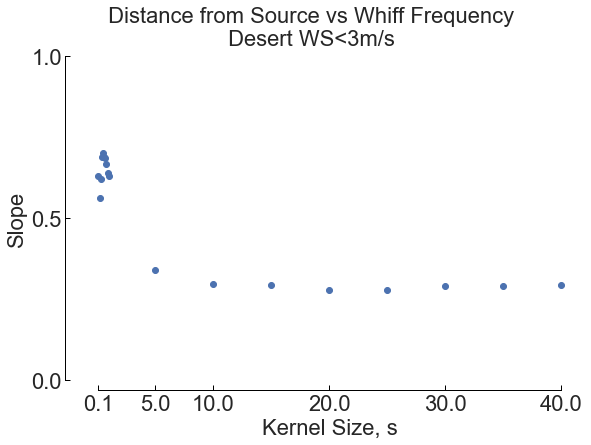

In [102]:
f,ax=plt.subplots(1,1,figsize=(8,6))
ax.scatter(kernel_size,sl)
ax.grid(False)
ax.set_xlabel('Kernel Size, s')
ax.set_ylabel('Slope')
mpl_functions.adjust_spines(ax,['left', 'bottom'],spine_locations={},
                            smart_bounds=True, xticks=[0.1,5,10,30,20,40], 
                            yticks=[-0,.5,1],linewidth=1)


f.suptitle(" Distance from Source vs Whiff Frequency\n Desert WS<3m/s")
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 22)
f.savefig('../../Figure/Slope_NWindy.jpeg', dpi=300, bbox_inches = "tight")

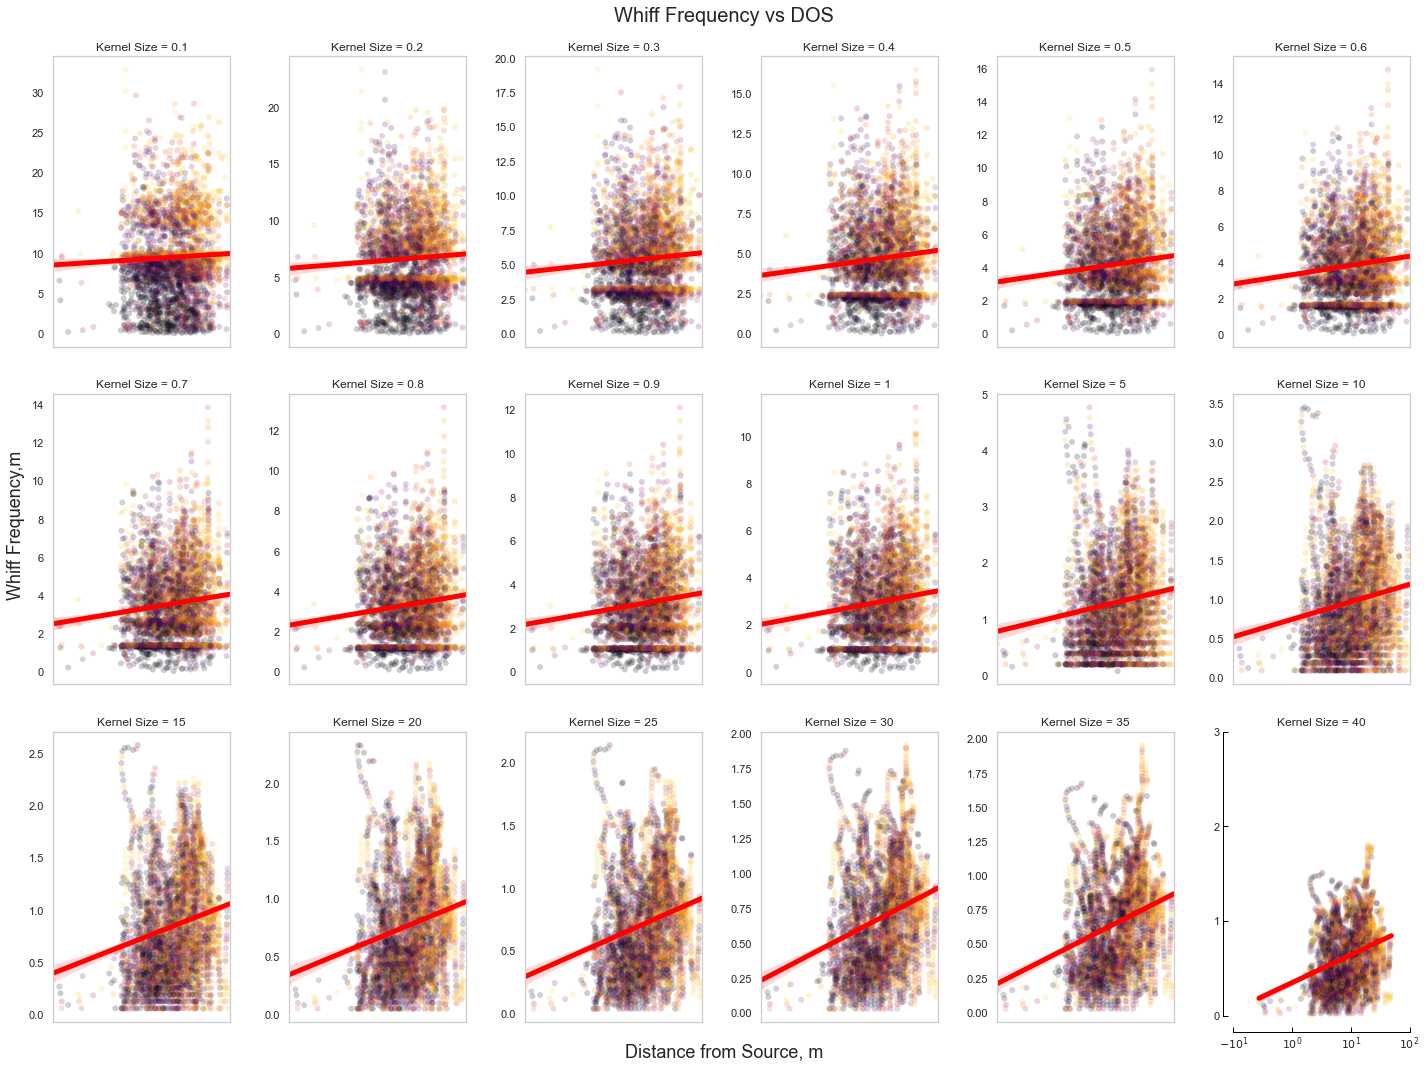

In [99]:
f,(ax)=plt.subplots(3,6,figsize=(20,15))
f.text(0.5, 0.008, 'Distance from Source, m', ha='center',fontsize=18)
f.text(0.002, 0.5, 'Whiff Frequency,m', va='center', rotation='vertical',fontsize=18)
f.suptitle("Whiff Frequency vs DOS", fontsize=20)
f.tight_layout(pad=2)
# figurefirst.mpl_functions.set_fontsize(f, 22)
##plots
# ax[0][0].plot(kernel_size,sl)
count=0
for i in range(3):
    for j in range(6):
        
        if (count ==17):
            var = ax[i][j].scatter(fdf.log_avg_dist_from_source, m_ef[count], c=fdf.mean_concentration, cmap='inferno_r', 
                edgecolors='none', alpha=0.2, vmin=4, vmax=10)
            ax[i][j].grid(False)
            g1 =sns.regplot(x="log_avg_dist_from_source",y="mean_ef_"+str(count), data=fdf, 
                    ax=ax[i][j], line_kws={'color':'red','linewidth':5}, scatter=False, truncate=True)
            g1.set(xlabel=None, ylabel=None)


            mpl_functions.adjust_spines(ax[i][j],['left','bottom'],spine_locations={}, 
                                smart_bounds=True,yticks=[0,1,2,3],xticks=[-1,0,1,2],
                                linewidth=1)
            ax[i][j].set_xticklabels([r'$-10^{1}$',r'$10^{0}$',r'$10^{1}$', r'$10^{2}$'])
            ax[i][j].set_title('Kernel Size = '+ str(kernel_size[count]))
            
        else:
            var = ax[i][j].scatter(fdf.log_avg_dist_from_source, m_ef[count], c=fdf.mean_concentration, cmap='inferno_r', 
                    edgecolors='none', alpha=0.2, vmin=4, vmax=10)
            ax[i][j].grid(False)
            g1 =sns.regplot(x="log_avg_dist_from_source",y="mean_ef_"+str(count), data=fdf, 
                    ax=ax[i][j], line_kws={'color':'red','linewidth':5}, scatter=False, truncate=True)
            g1.set(xlabel=None, ylabel=None)
            ax[i][j].get_xaxis().set_ticks([])
            ax[i][j].set_title('Kernel Size = '+ str(kernel_size[count]))
        count+=1
        
f.savefig('../../Figure/WhiffFrequency_LWS.jpeg', dpi=300, bbox_inches = "tight")

In [85]:
# for i in range(0,len(m_ef)):
#     f,ax1=plt.subplots(1,1,figsize=(8,6))

#     var1 = ax1.scatter(fdf.log_avg_dist_from_source, m_ef[i], c=fdf.mean_concentration, cmap='inferno_r', 
#                 edgecolors='none', alpha=0.2, vmin=4, vmax=10)
#     ax1.grid(False)

#     g1 =sns.regplot(x="log_avg_dist_from_source",y="mean_ef_"+str(i), data=fdf, 
#                 ax=ax1, line_kws={'color':'red','linewidth':5}, scatter=False, truncate=True)
#     g1.set(xlabel=None, ylabel=None)

#     ax1.set_ylabel('Whiff Frequency, hz')
#     ax1.set_xlabel('Distance from Source, m')

#     mpl_functions.adjust_spines(ax1,['left','bottom'],spine_locations={}, 
#                                 smart_bounds=True,
#                                 xticks=[-1,0.5,1.3],
#                                 yticks=[0,12],
#                                 linewidth=1)
#     ax1.set_xticklabels([r'-$10^{1}$',r'$10^{0.5}$', r'$10^{1.3}$'])

#     f.suptitle("Whiff Frequency vs DOS\n Kernel size ="+str(kernel_size[i])+" s")
#     f.tight_layout(pad=2)
#     figurefirst.mpl_functions.set_fontsize(f, 22)
#     f.savefig('../../Figure/WF_'+str(i)+'.jpeg', dpi=300, bbox_inches = "tight")

In [105]:
# fs=200
# nyq=fs*0.5
# cutoff_freq=(np.linspace(1,90,20)).astype(int)

# fpval=[]
# cfreq =[]
# rsquare=[]
# models=[]

# def load_data():
#     df = pd.read_hdf(dir+'Forest/ForestMA.h5')
#     return df

# for i in range(0,len(cutoff_freq)):
#     df = load_data()
#     sos = signal.butter(2, cutoff_freq[i], 'low',fs=200, output='sos')
#     filtered = signal.sosfilt(sos, df.odor)
#     df['filtered_odor']=filtered

#     index = osm.get_index_filtered(df)
#     fdf = pd.DataFrame()
#     np.seterr(divide = 'ignore') 
#     get_statistics(df,index,fdf)

#     whiff_frequency=smf.ols(formula='mean_ef ~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
#     whiff_duration=smf.ols(formula='log_whiff~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
#     moving_avg = smf.ols(formula='mean_ma ~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()

#     fdf['whiff_frequency_resid']=whiff_frequency.resid
#     fdf['whiff_duration_resid'] = whiff_duration.resid
#     fdf['moving_avg_resid'] = moving_avg.resid

#     distance=smf.ols(formula='log_avg_dist_from_source ~ whiff_duration_resid  + whiff_frequency_resid + moving_avg_resid', data=fdf).fit()
#     models.append(distance)
#     fpval.append(distance.f_pvalue)
#     rsquare.append(distance.rsquared)
#     cfreq.append(cutoff_freq[i])


In [7]:
# f,(ax1,ax2)=plt.subplots(2,1,figsize=(8,12))
# ax1.scatter(cutoff_freq, np.log10(fpval))
# ax2.scatter(cutoff_freq, rsquare)

# ax1.grid(False)
# ax2.grid(False)
# # ax1.set_yscale('log')
# mpl_functions.adjust_spines(ax1,['left'],spine_locations={},
#                             smart_bounds=True, yticks=[0,-7.5,-15],linewidth=1)

# mpl_functions.adjust_spines(ax2,['left', 'bottom'],spine_locations={},
#                             smart_bounds=True, xticks=[0,15,30,45,60,75,90],yticks=[0.002,0.008,0.014],linewidth=1)

# ax1.yaxis.set_label_coords(-0.20, 0.5)
# ax1.set_yticklabels([r'$10^{-15}$',r'$10^{-7.5}$', r'$10^{-0}$'])
# # ax1.set_xlabel('Cutoff Frequency, Hz')

# ax1.set_ylabel('log(F-Prob)')

# ax2.set_xlabel('Cutoff Frequency, Hz')
# ax2.set_ylabel('$R^{2}$')


# f.suptitle("$F-Prob$ & $R^{2}$ Forest\nLPF 0<Cutoff<90")
# f.tight_layout(pad=2)
# figurefirst.mpl_functions.set_fontsize(f, 22)
# f.savefig('../../Figure/LPF_Forest.jpeg', dpi=300, bbox_inches = "tight")

In [13]:
## calculation for moving average alignment
# newma=np.pad(df.ma_fraction,(200,0),mode='constant', constant_values=(0))
# newma=newma[:-200]

In [18]:
# df.to_hdf(dir+'NotWindy/NotWindyMASigned1.h5', key='df', mode='w')

### Odor Encounter Map Plots

In [47]:
df["distance_from_source_a"]=np.sqrt(df.distance_from_source**2 - df.nearest_from_streakline**2)
# df.distance_from_source_a = df.distance_from_source_a*df.xsign

In [52]:
df['xsign']=df['xsign'].replace(0,1)

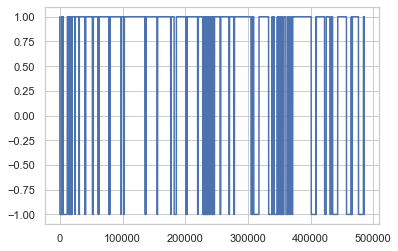

In [53]:
plt.plot(df.xsign)

In [54]:
dfdist=df

In [6]:
q='odor<4.5'
dfdist=df.query(q)

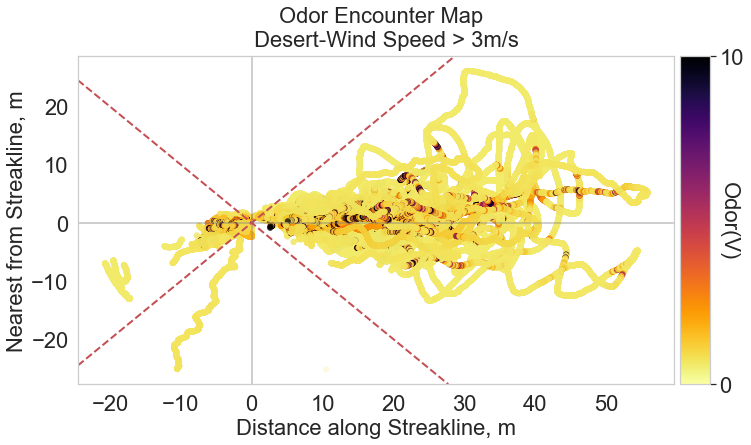

In [58]:
f,ax=plt.subplots(1,1,figsize=(10,6))
var = ax.scatter(dfdist.distance_from_source_a*dfdist.xsign,dfdist.nearest_from_streakline*dfdist.ysign,c=dfdist.odor, cmap="inferno_r",
           edgecolors='none', alpha=0.2, vmin=0, vmax=10)
# ax.set_xlim(-5,5)
ax.grid(False)
# ax.axline((0,0),slope=1, linestyle='dashed', linewidth=2, color='r')
ax.axhline(0, color = 'grey', alpha=0.5)
ax.axvline(0, color = 'grey', alpha=0.5)
# ax.axline((0, 0), slope=-1, linestyle='dashed', linewidth=2, color='r')
# ax.scatter(0,0,marker='o',  c='r')
# mpl_functions.adjust_spines(ax,['left', 'bottom'],spine_locations={},
#                             smart_bounds=True, xticks=[-5,0,5],yticks=[-50,0,45],linewidth=1)

ax.set_xlabel('Distance along Streakline, m')
ax.set_ylabel('Nearest from Streakline, m')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical', ticks=[0, 10])
cbar.ax.set_yticklabels(['0', '10'])
cbar.ax.set_ylabel('Odor(V)', rotation=-90, labelpad=-5)
cbar.solids.set(alpha=1)
f.suptitle("Odor Encounter Map \n Desert-Wind Speed > 3m/s")
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 22)
# f.savefig('../../Figure/Windyafter.jpeg', dpi=300, bbox_inches = "tight")

### Odor Statistics Calculation Plots

In [52]:
# f,(ax)=plt.subplots(4,1,figsize=(8.5,11))
# ##plots
# ax[0].plot(df.time,df.odor)
# # ax[0].axhline(4.5, linestyle='dashed', color='r')
# ax[0].set_xlim(1535,1540)
# ax[1].plot(df.time,df.whiff_plot)
# ax[1].set_xlim(1535,1540)
# # ax[2].plot(df.time,df.efreq)
# # ax[2].set_xlim(1535,1540)
# ax[2].plot(df.time, df.encounter_frequency)
# ax[2].set_xlim(1535,1540)
# ax[3].plot(df.time,df.ma_fraction)
# ax[3].set_xlim(1535,1540)

# ## adjust spines and grids
# for i in range(4):
#     ax[i].grid(False)
    
# mpl_functions.adjust_spines(ax[0],['left'],spine_locations={},smart_bounds=True, yticks=[0,10],linewidth=1)

# for i in range(1,3):
#     mpl_functions.adjust_spines(ax[i],['left'],spine_locations={},smart_bounds=True, yticks=[0,1],linewidth=1)

# mpl_functions.adjust_spines(ax[2],['left'],spine_locations={},
#                             smart_bounds=True, yticks=[0,5],linewidth=1)

# mpl_functions.adjust_spines(ax[3],['left', 'bottom'],spine_locations={},
#                             smart_bounds=True,yticks=[0,1],linewidth=1)

# ## label
# ax[0].set_ylabel('Odor, V')
# ax[1].set_ylabel('Whiff\nDuration, V')
# # ax[2].set_ylabel('Encounter\nOnsets')
# ax[2].set_ylabel('Encounter\nFrequency,Hz')
# ax[3].set_ylabel('Moving\nAverage, V')
# ax[3].set_xlabel('Time, s')


# f.suptitle("Odor Statistics Calculation\nOdor Threshold > 4.5V")
# f.tight_layout(pad=2)
# figurefirst.mpl_functions.set_fontsize(f, 22)
# f.savefig('../../Figure/OdorStat.jpeg', dpi=300, bbox_inches = "tight")

### Odor Statistics Plots

In [71]:
avg_dist_along_streakline = []
i = 0
while i<len(index):
    avg_dist_along_streakline.append(np.mean(df.distance_from_source_a[index[i]]))
    i+=1
fdf['avg_dist_along_streakline']=avg_dist_along_streakline

In [160]:
nfdf=(fdf-fdf.mean())/fdf.std()
# nfdf=(fdf-fdf.min())/(fdf.max()-fdf.min())

In [131]:
# q = 'length_of_encounter >=0.1'
# fdf=fdf.query(q)

In [154]:
q1='log_avg_dist_from_source_signed<0'
fdf1=nfdf.query(q1)
q2='log_avg_dist_from_source_signed>0'
fdf2=nfdf.query(q2)

In [123]:
dataframe=fdf2

In [124]:
a = dataframe.log_whiff
b = dataframe.log_avg_dist_from_source_signed
# mask = ~np.isnan(fdf.log_avg_dist_from_source)
# mask = np.isfinite(fdf.log_avg_dist_from_source) & np.isfinite(a)
slope, intercept, r_value, p_value, std_err = stats.linregress(b,a)
# slope, intercept, r_value, p_value, std_err = stats.linregress(fdf.log_avg_dist_from_source[mask],a[mask])

if p_value<=0.05:
    print ('significant')
    print("p_value:", p_value)
    print('r2_value:', r_value**2)
else:
    print ('insignificant')
    print("p_value:%.20f" %p_value)

significant
p_value: 0.0010711584232633708
r2_value: 0.0030365454960872085


In [147]:

# f,(ax1,ax2,ax3)=plt.subplots(3,1, figsize=(6,12))

# color_whiff = 'red'
# color_ef ='black'
# color_ma = 'black'
# var1 = ax1.scatter(dataframe.log_avg_dist_from_source_signed, dataframe.log_whiff, 
#                    c=dataframe.mean_concentration, cmap='inferno_r', 
#             edgecolors='none', alpha=0.2, vmin=4, vmax=10)
# ax1.grid(False)
# g1 =sns.regplot(x="log_avg_dist_from_source_signed",y="log_whiff", data=dataframe, 
#             ax=ax1, line_kws={'color':color_whiff,'linewidth':5}, scatter=False, truncate=True)
# g1.set(xlabel=None, ylabel=None)

# ax1.set_ylabel('Whiff Duration (s)')
# mpl_functions.adjust_spines(ax1,['left'],
#                             spine_locations={}, 
#                             smart_bounds=True,
                           
#                             yticks=[-2.4,-1,0,1.5],
#                             linewidth=1)
# ax1.yaxis.set_label_coords(-0.23, 0.5)
# ax1.set_yticklabels([r'$10^{-2.4}$',r'$10^{-1}$', r'$10^0$', r'$10^{1.5}$'])

# divider = make_axes_locatable(ax1)
# cax1 = divider.append_axes('right', size='5%', pad=0.08)
# cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical', ticks=[4, 10])
# cbar1.solids.set(alpha=1)
# cbar1.ax.set_yticklabels([])

# ########## subplot 1 #############

# var2 = ax2.scatter(dataframe.log_avg_dist_from_source_signed, dataframe.mean_ef, 
#                    c=dataframe.mean_concentration, cmap='inferno_r', 
#             edgecolors='none', alpha=0.2, vmin=4, vmax=10)
# ax2.grid(False)
# g2 = sns.regplot(x="log_avg_dist_from_source_signed",y="mean_ef", data=dataframe, 
#             ax=ax2, line_kws={'color':color_ef,'linewidth':5}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)
# # ax2.set_xlabel('Distance From Source (m)')
# ax2.set_ylabel('Whiff Frequency (Hz)')

# mpl_functions.adjust_spines(ax2,['left'],
#                             spine_locations={}, 
#                             smart_bounds=True,     
#                             yticks=[0,3.5,7],
#                             linewidth=1)
# ax2.yaxis.set_label_coords(-0.23, 0.5)

# divider = make_axes_locatable(ax2)
# cax2 = divider.append_axes('right', size='5%', pad=0.08)
# cbar2=f.colorbar(var2, cax=cax2, orientation = 'vertical', ticks=[4, 10])
# cbar2.solids.set(alpha=1)
# cbar2.ax.set_yticklabels([])


# ########## subplot 2 #############

# var3 = ax3.scatter(dataframe.log_avg_dist_from_source_signed, dataframe.mean_ma, 
#                    c=dataframe.mean_concentration, cmap='inferno_r', 
#                    edgecolors='none', alpha=0.2, vmin=4, vmax=10)
# ax3.grid(False)
# g3=sns.regplot(x="log_avg_dist_from_source_signed",y="mean_ma", data=dataframe, 
#             ax=ax3, line_kws={'color':color_ma,'linewidth':5}, scatter=False, truncate=False)
# g3.set(xlabel=None, ylabel=None)
# ax3.set_xlabel('Distance From Source (m)')
# ax3.set_ylabel('Whiff Moving\nAverage (V)')
# mpl_functions.adjust_spines(ax3,['left','bottom'],
#                             spine_locations={}, 
#                             smart_bounds=True,
#                             xticks=[0,1],
#                             yticks=[0,0.35,0.65,1],
#                             linewidth=1)
# ax3.yaxis.set_label_coords(-0.23, 0.5)
# ax3.set_xticklabels([r'$10^{0}$', r'$10^{1}$'])

# divider = make_axes_locatable(ax3)
# cax3 = divider.append_axes('right', size='5%', pad=0.08)
# cbar3=f.colorbar(var3, cax=cax3, orientation = 'vertical', ticks=[4, 10])
# cbar3.ax.set_yticklabels(['4.5', '10'])
# cbar3.solids.set(alpha=1)
# cbar3.ax.set_ylabel('Odor (V)', rotation=-90, labelpad=-5)


# ########## subplot 3 #############
# # f.suptitle('Desert\n Wind Speed > 3m/s')
# f.suptitle('Desert\n Wind Speed > 3m/s \n -ve x-axis')
# # f.suptitle("Forest\n0>WS>9m/s\n +ve x-axis")
# f.tight_layout(pad=1)
# figurefirst.mpl_functions.set_fontsize(f, 22)

# # f.savefig('../../Figure/negative.jpeg', dpi=300, bbox_inches = "tight")

In [155]:
dat=fdf2

In [156]:
whiff_frequency=smf.ols(formula='mean_ef ~ np.abs(avg_perpendicular_encounter) + np.abs(avg_parallel_encounter)', data=dat).fit()
whiff_duration=smf.ols(formula='log_whiff~ np.abs(avg_perpendicular_encounter) + np.abs(avg_parallel_encounter)', data=dat).fit()
moving_avg = smf.ols(formula='mean_ma ~ np.abs(avg_perpendicular_encounter) + np.abs(avg_parallel_encounter)', data=dat).fit()

In [157]:
dat['whiff_frequency_resid']=whiff_frequency.resid
dat['whiff_duration_resid'] = whiff_duration.resid
dat['moving_avg_resid'] = moving_avg.resid

In [158]:
# q1='log_avg_dist_from_source<0'
# fdf1=fdf.query(q1)
# q2='log_avg_dist_from_source>=0'
# fdf2=fdf.query(q2)

In [159]:
distance=smf.ols(formula='log_avg_dist_from_source~ whiff_duration_resid  + whiff_frequency_resid + moving_avg_resid', data=dat).fit()
print(distance.summary())

                               OLS Regression Results                               
Dep. Variable:     log_avg_dist_from_source   R-squared:                       0.022
Model:                                  OLS   Adj. R-squared:                  0.021
Method:                       Least Squares   F-statistic:                     26.07
Date:                      Thu, 14 Apr 2022   Prob (F-statistic):           1.13e-16
Time:                              09:40:49   Log-Likelihood:                 1944.1
No. Observations:                      3521   AIC:                            -3880.
Df Residuals:                          3517   BIC:                            -3855.
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [22]:
distance.pvalues.moving_avg_resid

0.005527962237646456

In [57]:
print("p_value:%.20f" %distance.pvalues.whiff_duration_resid)
print("p_value:%.20f" %distance.pvalues.whiff_frequency_resid)
print("p_value:%.20f" %distance.pvalues.moving_avg_resid)

p_value:0.07565366082193640540
p_value:0.00001460372401913663
p_value:0.00000000000010175297


In [89]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(distance.resid)
lzip(name, test)

[('Jarque-Bera', 80.82580865890148),
 ('Chi^2 two-tail prob.', 2.8112447152786083e-18),
 ('Skew', -0.36805972421530264),
 ('Kurtosis', 3.094341284576008)]

In [ ]:
## f,ax=plt.subplots(1,1,figsize=(15,8)) 
# mod = sm.graphics.plot_fit(distance, "mean_ef", ax=ax)
# ax.set_xlabel('Whiff Frequency')
# ax.set_ylabel('Distance From Source')
# ax.grid(False)
# mpl_functions.adjust_spines(ax,['left','bottom'],
#                             spine_locations={}, 
#                             smart_bounds=True,
#                             xticks=[0,4,8],
#                             yticks=[-20,20,55],
#                             linewidth=1)


# f.suptitle("Fitted Values Versus Whiff Frequency")
# f.tight_layout(pad=1)
# figurefirst.mpl_functions.set_fontsize(f, 22)


In [ ]:
# ## BootStrapping Results for Distance ~ Odor Statistics

# sns.set_style('whitegrid')
# f, ((ax1,ax2,ax3,ax4)) = plt.subplots(4,1, figsize=(16,14))
# ax1.plot(rdf.angles,rdf.rsquared)
# ax1.set_yticks([rdf.rsquared.min(), rdf.rsquared.max()])
# ax1.set_ylabel('$R^2$', rotation = 0, color='blue')
# set_grid_false(ax1)
# ax1.yaxis.set_label_coords(-0.04,0.45)
# ax1.axes.get_xaxis().set_visible(False)

# ax2.plot(rdf.angles,rdf.p_whiff_length)
# ax2.set_yticks([rdf.p_whiff_length.min(), rdf.p_whiff_length.max()])
# ax2.set_ylabel('$p-value$\nWhiff Duration', rotation = 0, color='blue')
# set_grid_false(ax2)
# ax2.yaxis.set_label_coords(-0.08,0.4)
# ax2.axes.get_xaxis().set_visible(False)

# ax3.plot(rdf.angles, rdf.p_encounter_frequency)
# ax3.set_yticks([rdf.p_encounter_frequency.min(),rdf.p_encounter_frequency.max()])
# ax3.set_ylabel('$p-value$\nEncounter Frequency', rotation = 0, color='blue')
# set_grid_false(ax3)
# ax3.yaxis.set_label_coords(-0.1,0.4)
# ax3.axes.get_xaxis().set_visible(False)

# ax4.plot(rdf.angles, rdf.p_moving_avg)
# ax4.set_yticks([rdf.p_moving_avg.min(),rdf.p_moving_avg.max()])
# ax4.set_xticks([45, 50, 55, 60, 65, 70, 75, 80, 85, 90])
# ax4.set_ylabel('$p-value$\nMoving Average', rotation = 0, color='blue')
# set_grid_false(ax4)
# ax4.yaxis.set_label_coords(-0.08,0.4)
# ax4.set_xlabel('Change in Direction', color='blue')

# f.suptitle('Wind Speed < 3m/s\nDistance ~ Odor-Statistics', fontsize='medium')
# f.tight_layout(pad=4)
# figurefirst.mpl_functions.set_fontsize(f, 18)
# # f.savefig('../../Figure/changeInDirNotWindy.jpeg', dpi=1000) 
# # f.savefig('../../Figure/removeddisc.svg', format='svg',dpi=1200)